# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer

In [4]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [5]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [254]:
X, y = read_dataset("spam")
# X, y = read_dataset("test.txt")

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [131]:
import math

In [267]:
class NaiveBayes:
    alpha = None
    freq = None
    label_count = None
    classes = None
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        labels = list(np.unique(y))
        self.classes = labels
        words_in_set = [0 for i in range(len(labels))]
        self.freq = [[0 for _ in range(len(labels))] for _ in range(len(X[0]))]
        label_count = [0 for _ in range(len(labels))]
        n = len(X)
        n_features = len(X[0])
        for i in range(n):
            x = X[i]
            label = labels.index(y[i]) # Найти номер лейбла
            for j in range(n_features):
                words_in_set[label]+=x[j] # Считаем количество слов для каждого класса
                self.freq[j][label]+=x[j] # И вероятности
        for i in range(n_features):
            for j in range(len(labels)):
                self.freq[i][j] = (self.freq[i][j] + self.alpha)/(self.alpha*n_features + words_in_set[j]) # Нормализуем
        for i in range(len(labels)):
            words_in_set[i] /= sum(words_in_set)
        self.label_count = words_in_set
        
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        res1 = []
        for i in range(len(X)):
            st=X[i]
            res = []
            for j in range(len(self.label_count)):
                p=0
                for word in range(len(st)):
                    if st[word] > 0:
                        p+=math.log(self.freq[word][j]) # Считаем нашу вероятность при наличии слова
#                         print("Word:", bow.res[word], "with prob", math.log(self.freq[word][j]))
                p+=math.log(self.label_count[j])
                res.append(p)
#             print(y_test[i])
#             print(res)
            res1.append(res)
        return res1
        

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [133]:
from collections import defaultdict

In [264]:
class BoW:
    res = None
    def __init__(self, X, voc_limit=1000):
        tmp = defaultdict(int)
        for st in X:
            for word in st.split():
                word = ''.join(x.lower() for x in word if x.isalpha()) # Очищаем слово
                if word != "":
                    tmp[word]+=1
        self.res = sorted(tmp.items(), key=lambda kv: kv[1], reverse = True)[:voc_limit] # Нашли самые частые слова
        self.res = list(map(lambda x: x[0], self.res))
#         print(self.res)
        
    def transform(self, X):
        result = []
        for st in X:
            res1 = []
            tmp = defaultdict(int)
            for word in st.split():
                word = ''.join(x.lower() for x in word if x.isalpha())
                if word != "":
                    tmp[word]+=1 # Считаем количество слов
            for el in self.res:
                res1.append(tmp[el])
            result.append(res1)
#         print(result)
        return result

In [265]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [268]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9835640138408305, 'spam': 0.7184873949579832},
 {'ham': 0.9443521594684385, 'spam': 0.9},
 0.9383070301291249)

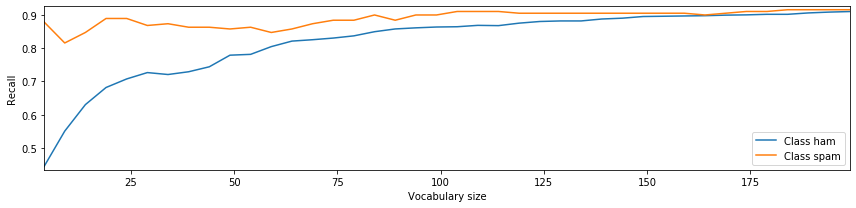

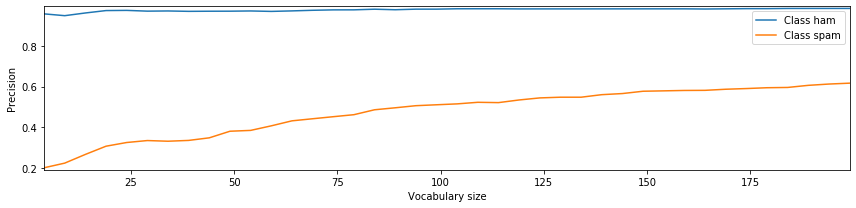

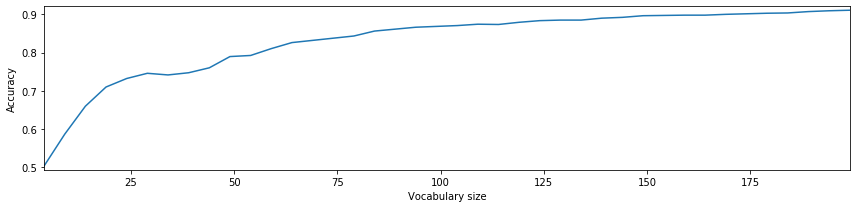

In [266]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [277]:
class BowStem:
    res = None
    def __init__(self, X, voc_limit=1000):
        tmp = defaultdict(int)
        stemmer = SnowballStemmer("english")
        for st in X:
            for word in st.split():
                word = ''.join(x.lower() for x in word if x.isalpha()) # Очищаем слово
                word = stemmer.stem(word)
                if word != "":
                    tmp[word]+=1
        self.res = sorted(tmp.items(), key=lambda kv: kv[1], reverse = True)[:voc_limit] # Нашли самые частые слова
        self.res = list(map(lambda x: x[0], self.res))
#         print(self.res)
        
    def transform(self, X):
        result = []
        stemmer = SnowballStemmer("english")
        for st in X:
            res1 = []
            tmp = defaultdict(int)
            for word in st.split():
                word = ''.join(x.lower() for x in word if x.isalpha())
                word = stemmer.stem(word)
                if word != "":
                    tmp[word]+=1 # Считаем количество слов
            for el in self.res:
                res1.append(tmp[el])
            result.append(res1)
#         print(result)
        return result

In [278]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [279]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9810017271157168, 'spam': 0.711864406779661},
 {'ham': 0.9435215946843853, 'spam': 0.8842105263157894},
 0.9354375896700143)

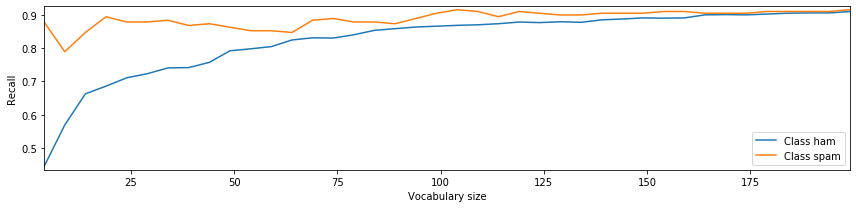

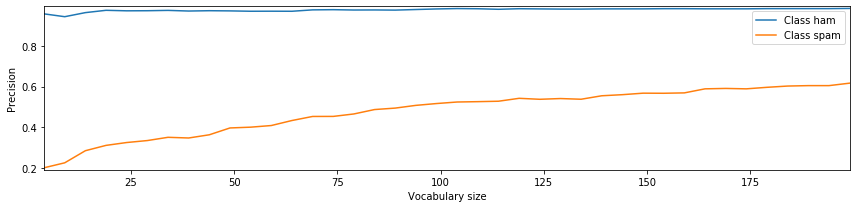

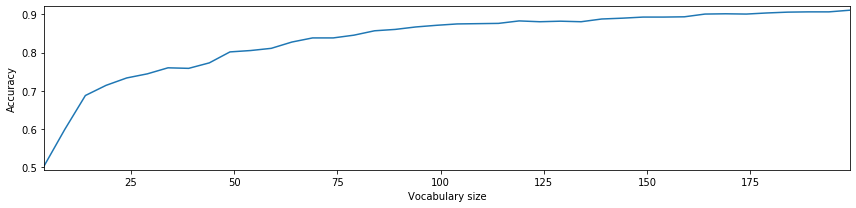

In [280]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)

Результаты со стеммингом оказались чуть хуже